In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install pyLDAvis

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import json
import pandas as pd
import numpy as np
import re
import string

from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english') #this depends on each language
from nltk.tokenize import word_tokenize
from nltk import tokenize
from nltk.stem import PorterStemmer
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models


# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


#Implementation of LDA

In [3]:
df = pd.read_csv('Review.csv')
df.head(3)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Num_words_text
0,0,226241,B002T0NWKE,A1G25CG7UWQ3XO,&#10003;Onoñda&#660;gegá&#660;,1,5,1,1309305600,Misleading discription-bad taste,they advertise that they contain aspartame die...,43
1,1,194272,B0009Y8AGI,A34Y9SS1F0H485,Bluemoon,0,6,1,1263600000,Yuck!,taste disgusting having struggle just keep dow...,27
2,2,359016,B003CIBPN8,ANDTRFIVWED40,R. Hauff,6,8,1,1275782400,"If you liked it in tetrapak box, don't buy now",bought this zico water hoping have good taste ...,53


In [4]:
df.drop(["Id","Unnamed: 0","ProductId", "UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Num_words_text"],inplace = True,axis = 1)

In [5]:
df["combine"]= df["Summary"]+" "+df["Text"]
data=df['combine'].values.tolist()
print(data[:3])

['Misleading discription-bad taste they advertise that they contain aspartame diet flavors boldly state high fructose corn syrup regular flavors contain sucralose artificial sweetners making taste awful disclaimer front bottle they legally call diet artificial sweetners anyway unless like drink diet drinks will like regular flavors either', 'Yuck! taste disgusting having struggle just keep down hope that does increase milk supply dont know even going finish trying mild maid next time since taste supposedly better', "If you liked it in tetrapak box, don't buy now bought this zico water hoping have good taste before unfortunately tastes horrible could bear drinking half bottle very funky taste from brazil sure know what young coconut water tastes likeand what they taste nowhere close real coconut water perhaps works those like aged coconut waterbr wish could return order never buying again back"]


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['misleading', 'discription', 'bad', 'taste', 'they', 'advertise', 'that', 'they', 'contain', 'aspartame', 'diet', 'flavors', 'boldly', 'state', 'high', 'fructose', 'corn', 'syrup', 'regular', 'flavors', 'contain', 'sucralose', 'artificial', 'sweetners', 'making', 'taste', 'awful', 'disclaimer', 'front', 'bottle', 'they', 'legally', 'call', 'diet', 'artificial', 'sweetners', 'anyway', 'unless', 'like', 'drink', 'diet', 'drinks', 'will', 'like', 'regular', 'flavors', 'either']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['misleading', 'discription', 'bad', 'taste', 'they', 'advertise', 'that', 'they', 'contain', 'aspartame', 'diet', 'flavors', 'boldly', 'state', 'high_fructose_corn_syrup', 'regular', 'flavors', 'contain', 'sucralose', 'artificial', 'sweetners', 'making', 'taste', 'awful', 'disclaimer', 'front', 'bottle', 'they', 'legally', 'call', 'diet', 'artificial', 'sweetners', 'anyway', 'unless', 'like', 'drink', 'diet', 'drinks', 'will', 'like', 'regular', 'flavors', 'either']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
#To run this code it is necessary to get the spacy moidel: "!python - m spacy download en", last depends on the used language 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Do lemmatization keeping only noun, adj, vb, adv
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mislead', 'discription', 'bad', 'taste', 'advertise', 'contain', 'aspartame', 'diet', 'flavor', 'boldly', 'state', 'high', 'fructose', 'corn', 'syrup', 'regular', 'flavor', 'contain', 'sucralose', 'artificial', 'sweetner', 'make', 'taste', 'awful', 'disclaimer', 'front', 'bottle', 'legally', 'call', 'diet', 'artificial', 'sweetner', 'anyway', 'drink', 'diet', 'drink', 'regular', 'flavor', 'either']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 3), (12, 1), (13, 1), (14, 2), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 2)]]


In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           alpha=0.05,
                                           eta =0.05,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)

In [12]:
# Print the top-30 Keyword in the 10 topics
pprint(lda_model.show_topics(num_words=30))
doc_lda = lda_model[corpus]

[(0,
  '0.059*"food" + 0.047*"love" + 0.033*"treat" + 0.022*"easy" + 0.021*"dog" + '
  '0.018*"best" + 0.018*"year" + 0.014*"time" + 0.014*"take" + 0.014*"month" + '
  '0.013*"give" + 0.011*"can" + 0.011*"problem" + 0.011*"product" + '
  '0.010*"week" + 0.010*"chicken" + 0.010*"day" + 0.010*"always" + '
  '0.009*"work" + 0.009*"get" + 0.009*"make" + 0.009*"last" + 0.009*"go" + '
  '0.009*"start" + 0.008*"meal" + 0.007*"piece" + 0.007*"chew" + '
  '0.007*"almond" + 0.007*"have" + 0.006*"seem"'),
 (1,
  '0.029*"gluten" + 0.026*"thank" + 0.022*"year" + 0.019*"light" + '
  '0.019*"quality" + 0.018*"favorite" + 0.016*"smooth" + 0.014*"soup" + '
  '0.014*"bean" + 0.013*"sometimes" + 0.013*"cup" + 0.012*"bring" + '
  '0.012*"roast" + 0.012*"home" + 0.012*"salad" + 0.011*"find" + '
  '0.010*"formula" + 0.010*"awesome" + 0.010*"mix" + 0.010*"bold" + '
  '0.009*"start" + 0.009*"caffeine" + 0.009*"wonderful" + 0.009*"recently" + '
  '0.008*"satisfy" + 0.008*"glad" + 0.008*"online" + 0.008*"egg" +

In [13]:
#inspect the topic distribution in each document corpus[i] is ith document
pprint(lda_model.get_document_topics(corpus[5], per_word_topics=True))

([(0, 0.76834977), (2, 0.11511043), (3, 0.052121934), (4, 0.05046438)],
 [(67, [0, 2]),
  (107, [0, 4, 2]),
  (111, [0, 3]),
  (112, [0]),
  (113, [0, 2]),
  (114, [2]),
  (115, [4]),
  (116, [0]),
  (117, [0, 2]),
  (118, [0, 2]),
  (119, [2]),
  (120, [0]),
  (121, [0, 2]),
  (122, [0, 2]),
  (123, [0]),
  (124, [0]),
  (125, [3]),
  (126, [0])],
 [(67, [(0, 0.85728985), (2, 0.14271016)]),
  (107, [(0, 1.9365041), (2, 0.029380314), (4, 0.034115504)]),
  (111, [(0, 0.92942756), (3, 0.07057241)]),
  (112, [(0, 1.9999999)]),
  (113, [(0, 1.8974072), (2, 0.10259275)]),
  (114, [(2, 1.0)]),
  (115, [(4, 0.9999886)]),
  (116, [(0, 1.0)]),
  (117, [(0, 0.9519315), (2, 0.048068475)]),
  (118, [(0, 0.98406917), (2, 0.015930794)]),
  (119, [(2, 1.0)]),
  (120, [(0, 1.0)]),
  (121, [(0, 0.96926165), (2, 0.02987726)]),
  (122, [(0, 0.9445161), (2, 0.055483896)]),
  (123, [(0, 1.0)]),
  (124, [(0, 1.0000001)]),
  (125, [(3, 0.99999994)]),
  (126, [(0, 0.99997395)])])


#Visualization of Topics

In [14]:
# Visualize the topics
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.327652  0.063330       1        1  45.070521
0      0.248868 -0.085088       2        1  10.677045
4     -0.078657 -0.021543       3        1   7.035253
9     -0.015270  0.266033       4        1   6.359856
5      0.059780  0.049844       5        1   6.054592
7     -0.222350  0.072323       6        1   5.216149
3     -0.117362 -0.224394       7        1   5.185251
6      0.010646 -0.236138       8        1   5.182729
1     -0.045717  0.093971       9        1   5.142082
8     -0.167590  0.021662      10        1   4.076523, topic_info=        Term         Freq        Total Category  logprob  loglift
176   coffee  3132.000000  3132.000000  Default  30.0000  30.0000
16    flavor  3746.000000  3746.000000  Default  29.0000  29.0000
57      good  6355.000000  6355.000000  Default  28.0000  28.0000
81      love  4561.000000  4561.000000  Default  27.0000  27.0000
223     food  2319.000000  2319.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
290    issue    90.231968   242.155975  Topic10  -4.9811   2.2127
444  include    87.704915   168.254720  Topic10  -5.0096   2.5484
316    stick    86.713841   161.619777  Topic10  -5.0209   2.5773
36      keep    90.890198   970.647683  Topic10  -4.9739   0.8316
428      eat    87.933876   860.150877  Topic10  -5.0069   0.9194

[463 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
201       4  0.283052        able
201       6  0.713292        able
640       1  0.999211  absolutely
95        1  0.999226         add
4103      7  0.999571      addict
...     ...       ...         ...
422       9  0.990540        wrap
432       2  0.555815        year
432       8  0.114036        year
432       9  0.329538        year
1302      7  0.995812       yummy

[545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 10, 6, 8, 4, 7, 2, 9])

In [15]:
def compute_coherence_values_ldamodel(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for nt in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=nt, 
                                           alpha=0.05,
                                           eta =0.05,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_ldamodel(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=6)

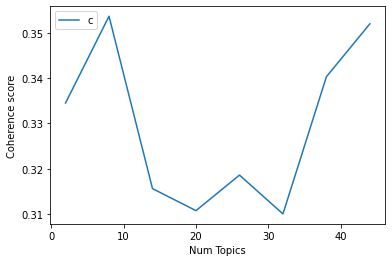

In [20]:
# Show graph
start=2; limit=50; step=6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3345
Num Topics = 8  has Coherence Value of 0.3536
Num Topics = 14  has Coherence Value of 0.3156
Num Topics = 20  has Coherence Value of 0.3108
Num Topics = 26  has Coherence Value of 0.3186
Num Topics = 32  has Coherence Value of 0.3101
Num Topics = 38  has Coherence Value of 0.3403
Num Topics = 44  has Coherence Value of 0.352


In [27]:

vis = gensimvis.prepare(model_list[1], corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.233342 -0.042295       1        1  32.820753
4      0.237822  0.090292       2        1  22.905441
0      0.217373 -0.061691       3        1  13.718903
5     -0.129963  0.253556       4        1   6.744302
1     -0.048812 -0.260579       5        1   6.489337
7     -0.042292  0.170288       6        1   6.240294
6     -0.203600 -0.169684       7        1   5.736933
3     -0.263870  0.020111       8        1   5.344036, topic_info=           Term         Freq        Total Category  logprob  loglift
176      coffee  3222.000000  3222.000000  Default  30.0000  30.0000
16       flavor  3630.000000  3630.000000  Default  29.0000  29.0000
138       store  1469.000000  1469.000000  Default  28.0000  28.0000
223        food  2238.000000  2238.000000  Default  27.0000  27.0000
57         good  6425.000000  6425.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
580        less   275.164508   578.801246   Topic8  -4.1369   2.1856
1742     packet   135.557721   209.074193   Topic8  -4.8449   2.4959
737      family   174.263980   377.700530   Topic8  -4.5937   2.1557
1452  sometimes   133.852070   245.613267   Topic8  -4.8575   2.3222
74          bag   172.230493   561.237607   Topic8  -4.6054   1.7479

[414 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
201       1  0.998586        able
640       2  0.863069  absolutely
640       6  0.136405  absolutely
95        1  0.293386         add
95        4  0.173438         add
...     ...       ...         ...
200       2  0.350329       would
200       3  0.074343       would
432       1  0.575264        year
432       3  0.424094        year
1302      7  0.997641       yummy

[511 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 6, 2, 8, 7, 4])

Notes: Seems like num_topics = 8 make more sense. I inspected topic number starting with 2 and having a step size 2. I estimated coherence value where topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. For num_topics=8, we can see a very good coherence value and the topics are interpretable, somewhat unique and exhaustive as inspected from visualization.

In [28]:
def compute_coherence_values_vary_alpha(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for a in np.arange(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           alpha=a,
                                           eta =0.05,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_vary_alpha(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=0.05, limit=0.26, step=0.05)

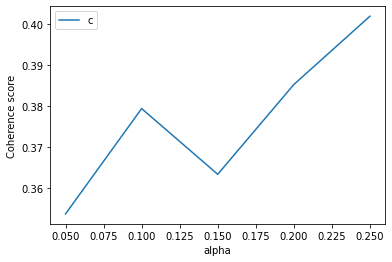

In [30]:
# Show graph
start=0.05; limit=0.26; step=0.05
x = np.arange(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("alpha =", m, " has Coherence Value of", round(cv, 4))

alpha = 0.05  has Coherence Value of 0.3536
alpha = 0.1  has Coherence Value of 0.3793
alpha = 0.15000000000000002  has Coherence Value of 0.3633
alpha = 0.2  has Coherence Value of 0.3852
alpha = 0.25  has Coherence Value of 0.4018


In [33]:
vis = gensimvis.prepare(model_list[1], corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.223014  0.037529       1        1  29.277455
4      0.219855 -0.105620       2        1  22.728307
0      0.198788  0.100391       3        1  13.765409
6     -0.147412  0.162515       4        1   7.374023
7     -0.007846 -0.209834       5        1   7.330414
5     -0.148117 -0.248957       6        1   6.922253
1     -0.042628  0.230712       7        1   6.696620
3     -0.295653  0.033264       8        1   5.905519, topic_info=           Term         Freq        Total Category  logprob  loglift
176      coffee  3242.000000  3242.000000  Default  30.0000  30.0000
16       flavor  3582.000000  3582.000000  Default  29.0000  29.0000
138       store  1453.000000  1453.000000  Default  28.0000  28.0000
223        food  2258.000000  2258.000000  Default  27.0000  27.0000
28        taste  4550.000000  4550.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1581     choice   110.335422   146.795579   Topic8  -5.1506   2.5438
1368       home   139.789438   359.183487   Topic8  -4.9140   1.8856
40         milk   163.467639   690.019852   Topic8  -4.7576   1.3892
1452  sometimes   121.496144   248.626590   Topic8  -5.0543   2.1132
74          bag   103.433716   557.220127   Topic8  -5.2152   1.1453

[424 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
95        1  0.375942        add
95        5  0.453668        add
95        6  0.169729        add
4103      5  0.995211     addict
1725      8  1.000797  addictive
...     ...       ...        ...
432       2  0.016469       year
432       3  0.406785       year
432       4  0.060935       year
432       7  0.053524       year
1302      4  0.997105      yummy

[529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 7, 8, 6, 2, 4])

Note: Looks like for alpha=0.10, we get good coherence score. This is actually pretty interesting, it seems coherence value starts to increase than decrease and then again increases. After doing visual inspect it seems alpha =0.1 is more optimum and the topics are interpretable, somewhat unique and exhaustive.

In [34]:
def compute_coherence_values_vary_beta(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for b in np.arange(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           alpha=0.10,
                                           eta = b,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_vary_beta(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=0.05, limit=0.26, step=0.05)

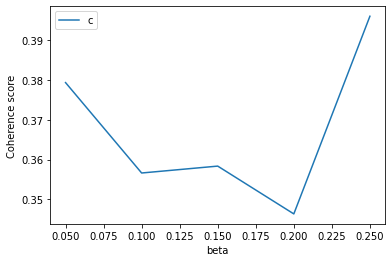

In [37]:
# Show graph
start=0.05; limit=0.26; step=0.05
x = np.arange(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("beta")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_vary_beta(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=0.01, limit=0.06, step=0.01)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


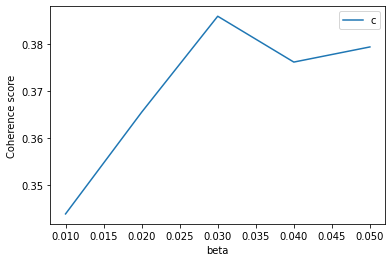

In [39]:
# Show graph
start=0.01; limit=0.06; step=0.01
x = np.arange(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("beta")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("beta =", m, " has Coherence Value of", round(cv, 4))

beta = 0.01  has Coherence Value of 0.344
beta = 0.02  has Coherence Value of 0.3655
beta = 0.03  has Coherence Value of 0.3858
beta = 0.04  has Coherence Value of 0.3761
beta = 0.05  has Coherence Value of 0.3793


In [41]:
vis = gensimvis.prepare(model_list[2], corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.197739 -0.062785       1        1  26.840880
4     -0.199063  0.121295       2        1  22.242784
0     -0.178692 -0.084638       3        1  14.177311
7     -0.066330  0.157770       4        1   8.185545
6      0.134193 -0.140712       5        1   7.841426
5      0.133967  0.272837       6        1   7.269399
1      0.038890 -0.262620       7        1   7.094905
3      0.334774 -0.001148       8        1   6.347751, topic_info=           Term         Freq        Total Category  logprob  loglift
176      coffee  3289.000000  3289.000000  Default  30.0000  30.0000
16       flavor  3620.000000  3620.000000  Default  29.0000  29.0000
28        taste  4515.000000  4515.000000  Default  28.0000  28.0000
138       store  1485.000000  1485.000000  Default  27.0000  27.0000
223        food  2271.000000  2271.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1368       home   156.361182   364.427286   Topic8  -4.8742   1.9109
365      little   176.361181  1759.967489   Topic8  -4.7539   0.4566
1452  sometimes   119.192796   249.755972   Topic8  -5.1456   2.0173
110        want   135.826191  1002.349444   Topic8  -5.0150   0.7583
21         make   113.333078  3500.389906   Topic8  -5.1961  -0.6732

[429 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
95        1  0.202313     add
95        4  0.415866     add
95        6  0.170200     add
95        7  0.211947     add
4103      4  1.001609  addict
...     ...       ...     ...
432       2  0.009924    year
432       3  0.442431    year
432       5  0.079389    year
432       7  0.076909    year
1302      5  1.000643   yummy

[552 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 8, 7, 6, 2, 4])

Note: Looks like for beta=0.03, we get good coherence score. I've actually done two rounds of inspection here and when inspected with small er step, it seems beta=0.03 is more optimum and the topics are interpretable, somewhat unique and exhaustive.

#Implement KL-divergence

In [42]:

# Select the model and print the topics
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           alpha=0.10,
                                           eta = 0.03,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
model_topics = optimal_model.show_topics(num_words=30,formatted=False)

In [43]:
topic_word_prob_list = []
for id,word_prob_distr in model_topics:
  #print(word_prob_distr)
  prob_distr = [p for w, p in word_prob_distr]
  topic_word_prob_list.append(prob_distr)

In [44]:
from gensim.matutils import kullback_leibler

num_topics = 8
for i in range(num_topics):
  for j in range(num_topics):
    if i==j:
      continue
    else:
      kl = 0
      print("KL Divergence between topic "+str(i)+" and "+str(j))
      kl+=kullback_leibler(topic_word_prob_list[i],topic_word_prob_list[j])+kullback_leibler(topic_word_prob_list[j],topic_word_prob_list[i])
      print(kl/2)

KL Divergence between topic 0 and 1
0.01943312957882881
KL Divergence between topic 0 and 2
0.009991815313696861
KL Divergence between topic 0 and 3
0.009128740057349205
KL Divergence between topic 0 and 4
0.005118636414408684
KL Divergence between topic 0 and 5
0.1221059113740921
KL Divergence between topic 0 and 6
0.006513669155538082
KL Divergence between topic 0 and 7
0.01572231575846672
KL Divergence between topic 1 and 0
0.01943312957882881
KL Divergence between topic 1 and 2
0.009915851056575775
KL Divergence between topic 1 and 3
0.032166577875614166
KL Divergence between topic 1 and 4
0.029516879469156265
KL Divergence between topic 1 and 5
0.1849323809146881
KL Divergence between topic 1 and 6
0.02604503370821476
KL Divergence between topic 1 and 7
0.005480926018208265
KL Divergence between topic 2 and 0
0.009991815313696861
KL Divergence between topic 2 and 1
0.009915851056575775
KL Divergence between topic 2 and 3
0.022329609841108322
KL Divergence between topic 2 and 4
0.0

In [45]:
vis = gensimvis.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.197739 -0.062785       1        1  26.840880
4     -0.199063  0.121295       2        1  22.242784
0     -0.178692 -0.084638       3        1  14.177311
7     -0.066330  0.157770       4        1   8.185545
6      0.134193 -0.140712       5        1   7.841426
5      0.133967  0.272837       6        1   7.269399
1      0.038890 -0.262620       7        1   7.094905
3      0.334774 -0.001148       8        1   6.347751, topic_info=           Term         Freq        Total Category  logprob  loglift
176      coffee  3289.000000  3289.000000  Default  30.0000  30.0000
16       flavor  3620.000000  3620.000000  Default  29.0000  29.0000
28        taste  4515.000000  4515.000000  Default  28.0000  28.0000
138       store  1485.000000  1485.000000  Default  27.0000  27.0000
223        food  2271.000000  2271.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1368       home   156.361182   364.427286   Topic8  -4.8742   1.9109
365      little   176.361181  1759.967489   Topic8  -4.7539   0.4566
1452  sometimes   119.192796   249.755972   Topic8  -5.1456   2.0173
110        want   135.826191  1002.349444   Topic8  -5.0150   0.7583
21         make   113.333078  3500.389906   Topic8  -5.1961  -0.6732

[429 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
95        1  0.202313     add
95        4  0.415866     add
95        6  0.170200     add
95        7  0.211947     add
4103      4  1.001609  addict
...     ...       ...     ...
432       2  0.009924    year
432       3  0.442431    year
432       5  0.079389    year
432       7  0.076909    year
1302      5  1.000643   yummy

[552 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 8, 7, 6, 2, 4])

After inspecting the KL divergence it seems the topics are somewhat dispersed.